In [157]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_context('talk', font_scale=1)

import numpy as np
import scipy.stats as stats

In [100]:
def fdr(p_vals):
    ranked_p_values = stats.rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    return fdr

In [138]:
novel = pd.read_csv('../../resources/catalog_tsv_standard/novel_v01.tsv', sep='\t')
trf = pd.read_csv('../../resources/catalog_tsv_standard/trf.tsv', sep='\t')

novel['name'] = 'novel'
trf['name'] = 'trf'

novel['period'] = ((novel['stop'] - novel['start']) / novel['motif'].str.len()).astype(int)
trf['period'] = ((trf['stop'] - trf['start']) / trf['motif'].str.len()).astype(int)

catalogs = pd.concat([novel, trf], ignore_index=True)

In [139]:
novel_counts = dict(novel.groupby('motif').size())
trf_counts = dict(trf.groupby('motif').size())

In [140]:
all_motifs = catalogs['motif'].unique()
novel_total = len(novel)
trf_total = len(trf)
novel_total, trf_total

(270884, 233266)

In [141]:
270884 * 0.12

32506.079999999998

In [142]:
p_enriched_all = []
p_depleted_all = []
n_novel = []
n_trf = []
motifs_to_remove = []
for i in range(len(all_motifs)):
    motif = all_motifs[i]
    novel_count = novel_counts[motif] if motif in novel_counts else 0
    trf_count = trf_counts[motif] if motif in trf_counts else 0
    n_novel.append(novel_count)
    n_trf.append(trf_count)
    
    if min(novel_count, trf_count) < 100:
        motifs_to_remove.append(i)
    
    table = [[novel_count, novel_total - novel_count],
             [trf_count, trf_total - trf_count]]
    odds_ratio, p_enriched = stats.fisher_exact(table, 'greater')
    odds_ratio, p_depleted = stats.fisher_exact(table, 'less')
    
    p_enriched_all.append(p_enriched)
    p_depleted_all.append(p_depleted)

In [143]:
data = pd.DataFrame({
    'motif': list(all_motifs),
    'p_enriched': p_enriched_all,
    'p_depleted': p_depleted_all,
    'n_novel': n_novel,
    'n_trf': n_trf,
})

data = data.drop(motifs_to_remove, axis='rows')

In [144]:
data['q_enriched'] = fdr(data['p_enriched'])
data['q_depleted'] = fdr(data['p_depleted'])

In [145]:
data['q_enriched'].min(), data['q_depleted'].min()

(0.0, 3.0717641970669994e-205)

In [146]:
thresh = 0.01
sig = data[(data['q_enriched'] < thresh) & (data['q_depleted'] < thresh)]
enriched_sig = data[data['q_enriched'] < thresh]
depleted_sig = data[data['q_depleted'] < thresh]

In [147]:
len(enriched_sig), len(depleted_sig)

(19, 85)

In [148]:
', '.join(enriched_sig['motif'])

'GA, CT, GT, AC, TA, TG, AG, GATA, TC, CA, AT, AGAC, AAAC, TTTG, TCTG, CAC, AACA, TAA, GAAAA'

In [149]:
', '.join(depleted_sig['motif'])

'AAAAT, AAAT, CTTT, AGAA, AAAG, CTTTT, TTTA, TATTT, AATA, TTTC, TTTTG, AAGG, GAGG, TCTT, AAAAC, GTTTT, CCT, TTTTA, AAG, AAT, TCC, AATG, AAAACA, TTCC, TGAA, ATTT, CAAA, AGGA, TTTTC, TCCA, GGA, TATT, ATGG, AAC, TTCTT, CCTT, TATC, TCCT, AGG, ATGA, CATT, TGTT, GTTT, TTTAT, ATAG, AGAT, TAGA, GGAA, AATAA, TGTTT, TTG, ATTC, TTGTT, GAAG, CTCC, CTC, AGGG, TTATT, TGT, TTCA, GAG, ACAAA, AAAAAC, AAACA, ATC, TTTGT, TTTTTG, TTTCT, AAAAG, CTTC, CTAT, CAAAA, ATAAA, ATTTT, TCTTT, TCA, TTTTGT, AAAAAG, ATG, AAAAAT, TAAAA, TTTTTC, CAAAAA, AACAA, GGGAGA'

In [150]:
enriched_sig['motif'].str.len().mean(), enriched_sig['motif'].str.len().median()

(2.8947368421052633, 2.0)

In [151]:
depleted_sig['motif'].str.len().mean(), depleted_sig['motif'].str.len().median()

(4.341176470588235, 4.0)

In [152]:
stats.ttest_ind(enriched_sig['motif'].str.len(), depleted_sig['motif'].str.len(), equal_var=False)

Ttest_indResult(statistic=-5.588816691763787, pvalue=9.451381523740267e-06)

In [153]:
stats.ttest_ind(novel['motif'].str.len(), trf['motif'].str.len(), equal_var=False)

Ttest_indResult(statistic=-119.05456043883657, pvalue=0.0)

In [154]:
# to_predict = []
# for motif in sig['motif']:
#     novel_periods = novel.loc[novel['motif'] == motif, 'period']
#     trf_periods = list(trf.loc[trf['motif'] == motif, 'period'])
# #     periods = set(novel_periods + trf_periods)
# #     periods = set(novel_periods)
# #     for p in periods:
# #         to_predict.append(motif * p)
#     to_predict.append(motif * int(novel_periods.median()))

Text(0, 0.5, 'Enrichement')

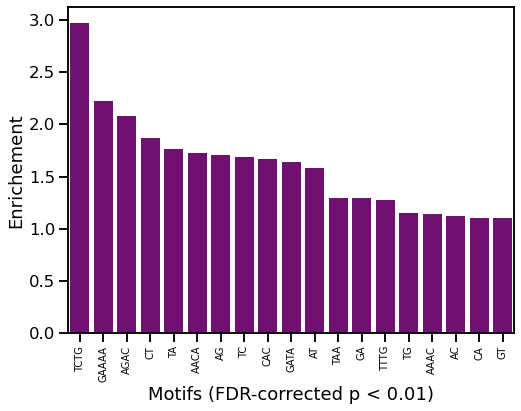

In [168]:
enriched = True

sig = enriched_sig.copy() if enriched else depleted_sig.copy()

sig = sig.head(20)

novel_subset = novel[novel['motif'].isin(sig['motif'])]
novel_pct_df = pd.DataFrame(novel_subset.groupby(['motif']).size() / len(novel)).reset_index()
novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
novel_pct_df['name'] = 'novel'

trf_subset = trf[trf['motif'].isin(sig['motif'])]
trf_pct_df = pd.DataFrame(trf_subset.groupby(['motif']).size() / len(trf)).reset_index()
trf_pct_df = trf_pct_df.rename({0: 'percentage'}, axis='columns')
trf_pct_df['name'] = 'trf'

sig['pct_novel'] = sig['n_novel'] / len(novel)
sig['pct_trf'] = sig['n_trf'] / len(trf)
sig['metric'] = (sig['pct_novel'] / sig['pct_trf']) if enriched else (sig['pct_trf'] / sig['pct_novel'])

pct_df = pd.concat([novel_pct_df, trf_pct_df], ignore_index=True)
pct_df['motif_len'] = pct_df['motif'].str.len()
pct_df = pct_df.sort_values(['motif_len', 'motif'], ignore_index=True)

sig['motif_len'] = sig['motif'].str.len()
sig = sig.sort_values(['metric', 'motif_len', 'motif'], ignore_index=True, ascending=False)


fig, ax = plt.subplots(figsize=(8, 6))
# ax = sns.barplot(x="motif", y="metric", hue="name", data=pct_df, ax=ax)
ax = sns.barplot(x="motif", y="metric", data=sig, ax=ax, color='purple')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_xlabel('Motifs (FDR-corrected p < 0.01)')
ax.set_ylabel('Enrichement' if enriched else 'Depletion')

In [132]:
subset = catalogs[catalogs['motif'].isin(sig['motif'])]
pd.DataFrame(subset.groupby(['motif', 'name']).size()).reset_index()

,motif,name,0
0,AAAC,novel,3724
1,AAAC,trf,2817
2,AACA,novel,276
3,AACA,trf,138
4,AC,novel,30118
5,AC,trf,23119
6,AG,novel,6895
7,AG,trf,3475
8,AGAC,novel,329
9,AGAC,trf,136


In [134]:
novel_subset = novel[novel['motif'].isin(sig['motif'])]
novel_pct_df = pd.DataFrame(subset.groupby(['motif']).size() / len(novel)).reset_index()
novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
novel_pct_df['name'] = 'novel'

In [ ]:
novel_subset = novel[novel['motif'].isin(sig['motif'])]
novel_pct_df = pd.DataFrame(subset.groupby(['motif']).size() / len(novel)).reset_index()
novel_pct_df = novel_pct_df.rename({0: 'percentage'}, axis='columns')
novel_pct_df['name'] = 'novel'